##### [sample solution, trained for a few hours (not converged)]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="seaquest"

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)

#number of parallel agents and batch sequence length (frames)
# lower n_agent because i am using GPU with 8GB of memory
N_AGENTS = 7
SEQ_LENGTH = 5

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

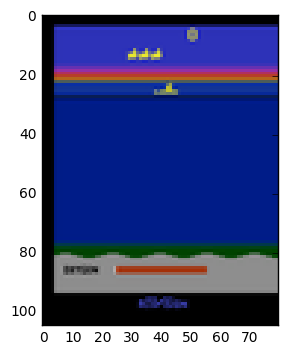

In [3]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [4]:
import lasagne, theano

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


Lets try to use window augmentation and grayscale images. Here is the modified input

In [5]:
from lasagne.layers import InputLayer, DimshuffleLayer, ReshapeLayer
from lasagne.layers import FeaturePoolLayer
from agentnet.memory import GRUCell, WindowAugmentation

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))
grayscale_observation_layer = FeaturePoolLayer(observation_layer, pool_size=3, axis=3, pool_function=theano.tensor.mean)
print(grayscale_observation_layer.output_shape)

#reshape to [sample, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(grayscale_observation_layer,(0,3,1,2))
observation_reshape = ReshapeLayer(observation_reshape, shape=([0], [2], [3]))
print(observation_reshape.output_shape)


windows_state = InputLayer( (None,2,IMAGE_W, IMAGE_H) )

new_window_state = WindowAugmentation(observation_reshape, windows_state)
print(new_window_state.output_shape)
memory_dict = {new_window_state: windows_state}

(None, 105, 80, 1)
(None, 105, 80)
(None, 2, 105, 80)


In [6]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(new_window_state,16,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),32,filter_size=(4,4),stride=(2,2),name='conv1')

conv2 = Conv2DLayer(batch_norm(conv1),64,filter_size=(4,4),stride=(2,2),name='conv2')

dense0 = DenseLayer(batch_norm(conv2),256,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [7]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = atari.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [8]:
from agentnet.agent import Agent
#all together
# we need to mass memory_dict to agent so it's aware of window augmentation
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer,
              agent_states=memory_dict)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 conv2.W,
 conv2_bn.beta,
 conv2_bn.gamma,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [10]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE,max_size=10000)


In [11]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log][:2])
print(reward_log[:2])

[['NOOP' 'DOWNRIGHT' 'NOOP' 'DOWN' 'DOWNRIGHT' 'DOWNFIRE' 'DOWNFIRE']
 ['NOOP' 'DOWNRIGHT' 'DOWNRIGHT' 'DOWN' 'RIGHTFIRE' 'DOWNRIGHT' 'DOWNRIGHT']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 140 ms, sys: 4 ms, total: 144 ms
Wall time: 142 ms


In [12]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [13]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [14]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [15]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [16]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [17]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-10-28 19:00:24,641] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:00:24,642] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:00:24,667] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.0.24602.video000000.mp4
[2016-10-28 19:00:27,280] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 659 timesteps with reward=20.0


In [18]:
from IPython.display import HTML

video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

iter=10	epsilon=0.496	reward/step=0.00000
iter=20	epsilon=0.491	reward/step=0.00000
iter=30	epsilon=0.487	reward/step=0.09217
iter=40	epsilon=0.482	reward/step=0.16725
iter=50	epsilon=0.478	reward/step=0.13445
iter=60	epsilon=0.474	reward/step=0.11241
iter=70	epsilon=0.470	reward/step=0.11268
iter=80	epsilon=0.465	reward/step=0.13404
iter=90	epsilon=0.461	reward/step=0.13815


[2016-10-28 19:01:04,441] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:01:04,442] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:01:04,466] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.1.24602.video000000.mp4


iter=100	epsilon=0.457	reward/step=0.14710


[2016-10-28 19:01:15,972] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 2929 timesteps with reward=460.0


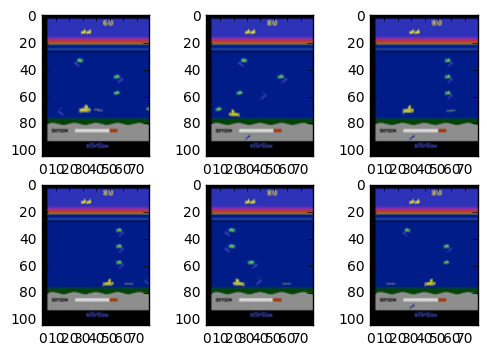

iter=110	epsilon=0.453	reward/step=0.14929
iter=120	epsilon=0.449	reward/step=0.15112
iter=130	epsilon=0.445	reward/step=0.15267
iter=140	epsilon=0.441	reward/step=0.15400
iter=150	epsilon=0.437	reward/step=0.15894
iter=160	epsilon=0.433	reward/step=0.15617
iter=170	epsilon=0.430	reward/step=0.15706
iter=180	epsilon=0.426	reward/step=0.15785
iter=190	epsilon=0.422	reward/step=0.15557


[2016-10-28 19:02:25,392] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:02:25,393] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:02:25,416] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.2.24602.video000000.mp4


iter=200	epsilon=0.418	reward/step=0.15920


[2016-10-28 19:02:32,911] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 1921 timesteps with reward=260.0


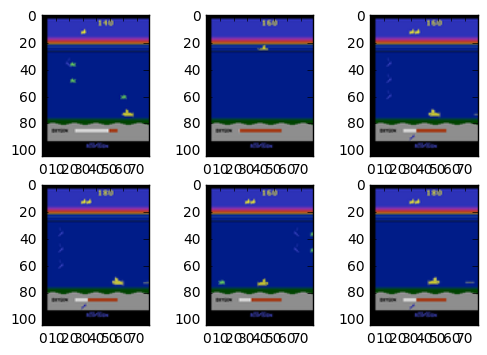

iter=210	epsilon=0.415	reward/step=0.15437
iter=220	epsilon=0.411	reward/step=0.15772
iter=230	epsilon=0.408	reward/step=0.15584
iter=240	epsilon=0.404	reward/step=0.15886
iter=250	epsilon=0.400	reward/step=0.15709
iter=260	epsilon=0.397	reward/step=0.15764
iter=270	epsilon=0.394	reward/step=0.15814
iter=280	epsilon=0.390	reward/step=0.15252
iter=290	epsilon=0.387	reward/step=0.15317


[2016-10-28 19:04:15,501] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:04:15,501] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:04:15,525] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.3.24602.video000000.mp4


iter=300	epsilon=0.383	reward/step=0.15377


[2016-10-28 19:04:24,628] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 2325 timesteps with reward=400.0


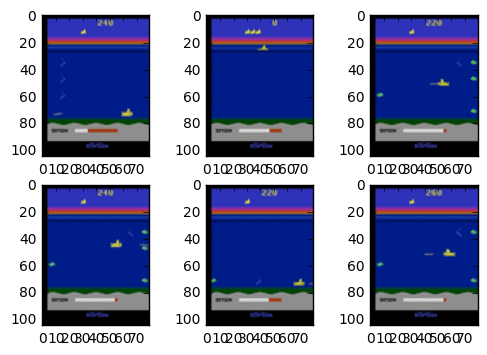

iter=310	epsilon=0.380	reward/step=0.15618
iter=320	epsilon=0.377	reward/step=0.15843
iter=330	epsilon=0.374	reward/step=0.15537
iter=340	epsilon=0.370	reward/step=0.15752
iter=350	epsilon=0.367	reward/step=0.15792
iter=360	epsilon=0.364	reward/step=0.15354
iter=370	epsilon=0.361	reward/step=0.15248
iter=380	epsilon=0.358	reward/step=0.14998
iter=390	epsilon=0.355	reward/step=0.15345


[2016-10-28 19:06:39,682] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:06:39,683] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:06:39,707] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.4.24602.video000000.mp4


iter=400	epsilon=0.352	reward/step=0.15248


[2016-10-28 19:06:46,233] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 1665 timesteps with reward=260.0


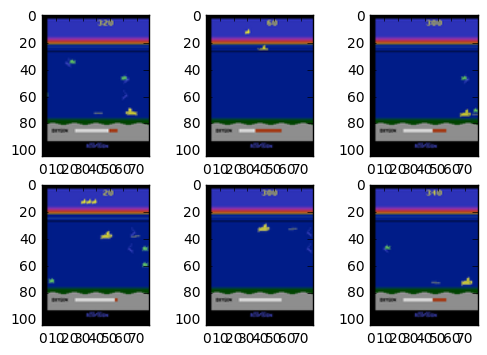

iter=410	epsilon=0.349	reward/step=0.15294
iter=420	epsilon=0.346	reward/step=0.15609
iter=430	epsilon=0.343	reward/step=0.15512
iter=440	epsilon=0.340	reward/step=0.15549
iter=450	epsilon=0.337	reward/step=0.15331
iter=460	epsilon=0.334	reward/step=0.15494
iter=470	epsilon=0.331	reward/step=0.15529
iter=480	epsilon=0.328	reward/step=0.15919
iter=490	epsilon=0.326	reward/step=0.15828


[2016-10-28 19:09:34,904] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:09:34,905] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:09:34,929] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.5.24602.video000000.mp4


iter=500	epsilon=0.323	reward/step=0.15740


[2016-10-28 19:09:47,977] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 3343 timesteps with reward=560.0


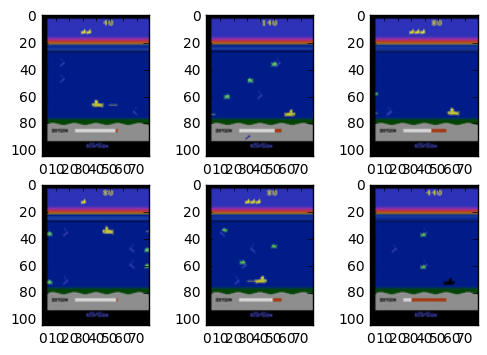

iter=510	epsilon=0.320	reward/step=0.15767
iter=520	epsilon=0.318	reward/step=0.15794
iter=530	epsilon=0.315	reward/step=0.15819
iter=540	epsilon=0.312	reward/step=0.15949
iter=550	epsilon=0.310	reward/step=0.15867
iter=560	epsilon=0.307	reward/step=0.15890
iter=570	epsilon=0.304	reward/step=0.15912
iter=580	epsilon=0.302	reward/step=0.15736
iter=590	epsilon=0.299	reward/step=0.15954


[2016-10-28 19:13:07,209] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:13:07,210] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:13:07,237] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.6.24602.video000000.mp4


iter=600	epsilon=0.297	reward/step=0.15973


[2016-10-28 19:13:17,386] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 2581 timesteps with reward=440.0


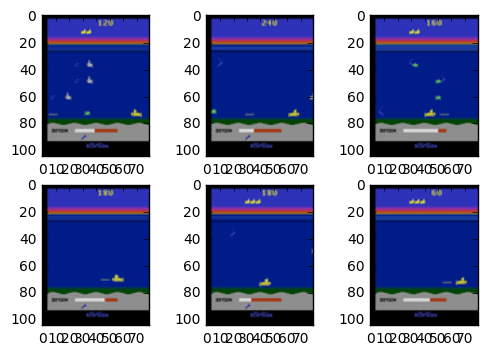

iter=610	epsilon=0.295	reward/step=0.15993
iter=620	epsilon=0.292	reward/step=0.16103
iter=630	epsilon=0.290	reward/step=0.16120
iter=640	epsilon=0.287	reward/step=0.16136
iter=650	epsilon=0.285	reward/step=0.16239
iter=660	epsilon=0.283	reward/step=0.16252
iter=670	epsilon=0.280	reward/step=0.16095
iter=680	epsilon=0.278	reward/step=0.15943
iter=690	epsilon=0.276	reward/step=0.15960


[2016-10-28 19:16:42,453] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:16:42,453] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:16:42,477] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.7.24602.video000000.mp4


iter=700	epsilon=0.273	reward/step=0.15896


[2016-10-28 19:16:45,856] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 921 timesteps with reward=100.0


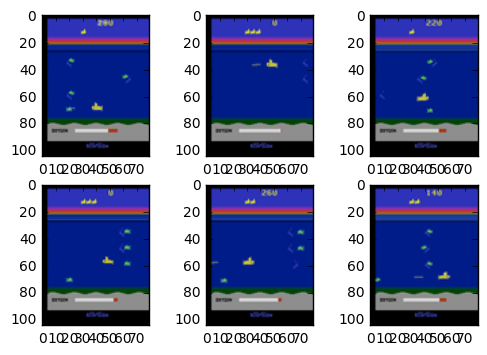

iter=710	epsilon=0.271	reward/step=0.15913
iter=720	epsilon=0.269	reward/step=0.15851
iter=730	epsilon=0.267	reward/step=0.15791
iter=740	epsilon=0.265	reward/step=0.15655
iter=750	epsilon=0.263	reward/step=0.15674
iter=760	epsilon=0.260	reward/step=0.15694
iter=770	epsilon=0.258	reward/step=0.15712
iter=780	epsilon=0.256	reward/step=0.15658
iter=790	epsilon=0.254	reward/step=0.15532


[2016-10-28 19:20:14,009] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:20:14,010] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:20:14,033] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.8.24602.video000000.mp4


iter=800	epsilon=0.252	reward/step=0.15695


[2016-10-28 19:20:23,266] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 2497 timesteps with reward=380.0


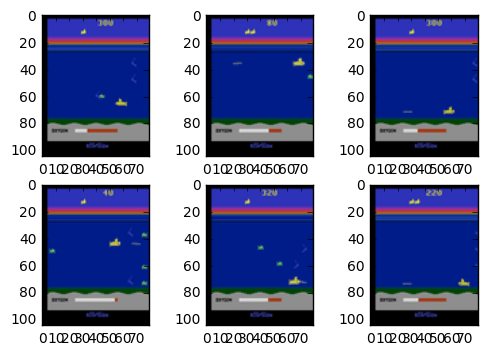

iter=810	epsilon=0.250	reward/step=0.15642
iter=820	epsilon=0.248	reward/step=0.15591
iter=830	epsilon=0.246	reward/step=0.15678
iter=840	epsilon=0.244	reward/step=0.15492
iter=850	epsilon=0.242	reward/step=0.15444
iter=860	epsilon=0.240	reward/step=0.15464
iter=870	epsilon=0.239	reward/step=0.15549
iter=880	epsilon=0.237	reward/step=0.15502
iter=890	epsilon=0.235	reward/step=0.15392


[2016-10-28 19:24:17,474] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:24:17,474] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:24:17,498] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.9.24602.video000000.mp4


iter=900	epsilon=0.233	reward/step=0.15348


[2016-10-28 19:24:24,460] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 1807 timesteps with reward=180.0


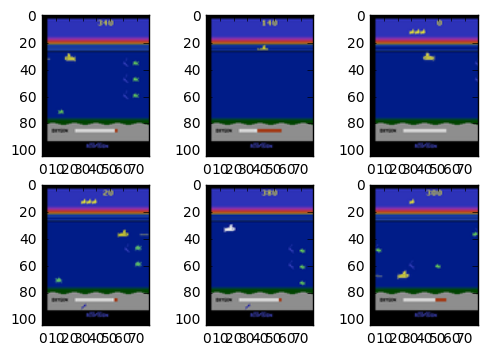

iter=910	epsilon=0.231	reward/step=0.15305
iter=920	epsilon=0.229	reward/step=0.15201
iter=930	epsilon=0.228	reward/step=0.15099
iter=940	epsilon=0.226	reward/step=0.15121
iter=950	epsilon=0.224	reward/step=0.15142
iter=960	epsilon=0.222	reward/step=0.15163
iter=970	epsilon=0.221	reward/step=0.15242
iter=980	epsilon=0.219	reward/step=0.15145
iter=990	epsilon=0.217	reward/step=0.15223


[2016-10-28 19:28:43,048] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:28:43,048] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-28 19:28:43,072] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.10.24602.video000000.mp4


iter=1000	epsilon=0.216	reward/step=0.15071


[2016-10-28 19:28:52,605] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 2603 timesteps with reward=440.0


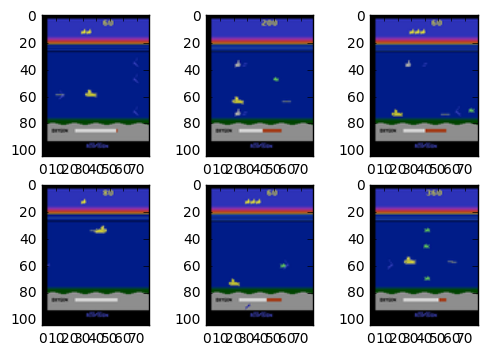

In [19]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}
#the loop may take eons to finish.
#consider interrupting early.
for i in range(1000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for i in range(5):
        loss = train_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        

    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=True)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

In [20]:
print(1)

1


# Evaluating results
 * Here we plot learning curves and sample testimonials

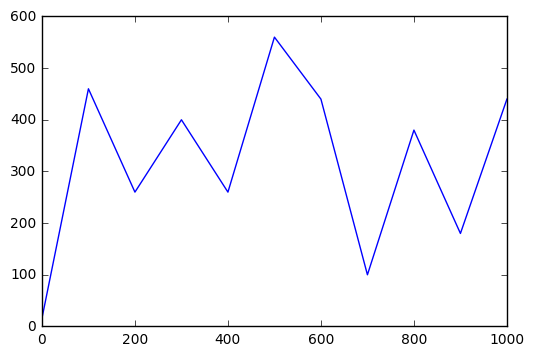

In [21]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [22]:
action_layer.epsilon.set_value(0.2)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%rw)

[2016-10-28 19:29:40,060] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:29:40,060] Clearing 4 monitor files from previous run (because force=True was provided)


Episode finished after 2541 timesteps with reward=380.0
Episode finished after 3253 timesteps with reward=460.0
Episode finished after 2189 timesteps with reward=300.0
Episode finished after 1977 timesteps with reward=340.0
Episode finished after 1995 timesteps with reward=300.0
Episode finished after 3125 timesteps with reward=460.0
Episode finished after 2909 timesteps with reward=460.0
Episode finished after 2473 timesteps with reward=400.0
Episode finished after 3003 timesteps with reward=420.0
Episode finished after 2001 timesteps with reward=300.0
Episode finished after 2005 timesteps with reward=300.0
Episode finished after 1975 timesteps with reward=320.0
Episode finished after 2255 timesteps with reward=420.0
Episode finished after 1107 timesteps with reward=200.0
Episode finished after 2177 timesteps with reward=320.0
Episode finished after 2815 timesteps with reward=400.0
Episode finished after 1061 timesteps with reward=120.0
Episode finished after 1439 timesteps with rewar

[2016-10-28 19:31:58,767] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 2013 timesteps with reward=360.0
mean session score=339.000000.5


In [23]:
pool.evaluate(n_games=20,save_path="./records",record_video=True)

[2016-10-28 19:40:12,175] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 19:40:12,176] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-10-28 19:40:12,199] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.12.24602.video000000.mp4
[2016-10-28 19:40:24,586] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.12.24602.video000001.mp4


Episode finished after 3395 timesteps with reward=540.0
Episode finished after 2217 timesteps with reward=300.0
Episode finished after 2719 timesteps with reward=440.0
Episode finished after 1805 timesteps with reward=280.0
Episode finished after 2629 timesteps with reward=420.0
Episode finished after 3241 timesteps with reward=560.0
Episode finished after 1973 timesteps with reward=240.0


[2016-10-28 19:41:16,742] Starting new video recorder writing to /root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records/openaigym.video.12.24602.video000008.mp4


Episode finished after 1987 timesteps with reward=300.0
Episode finished after 2045 timesteps with reward=280.0
Episode finished after 2537 timesteps with reward=360.0
Episode finished after 2099 timesteps with reward=320.0
Episode finished after 2371 timesteps with reward=400.0
Episode finished after 1889 timesteps with reward=260.0
Episode finished after 1901 timesteps with reward=240.0
Episode finished after 1675 timesteps with reward=220.0
Episode finished after 2795 timesteps with reward=460.0
Episode finished after 1659 timesteps with reward=260.0
Episode finished after 2153 timesteps with reward=340.0
Episode finished after 2845 timesteps with reward=500.0


[2016-10-28 19:42:39,197] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/notebooks/ml-fall-2016/hw07-reinforcement-learning/records')


Episode finished after 2347 timesteps with reward=340.0


353.0

In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__